Preamble: import these plotting utilities

In [375]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# A large matrix dataset: coauthorship among physicists

+ Coauthorship among physicists based arXiv postings in `astro-ph`
+ The graph contains $N = 18772$ nodes, which correspond to unique authors observed over the period 1993 -- 2003
+ If Author i and Author j coauthored a paper during that period, the nodes are connected
+ In order to analyze this large graph, we will downsample it to a smaller graph with $N = 1000$ nodes representing the most highly-connected authors
+ This dataset is from the [Stanford SNAP database](https://snap.stanford.edu/data/ca-CondMat.html)



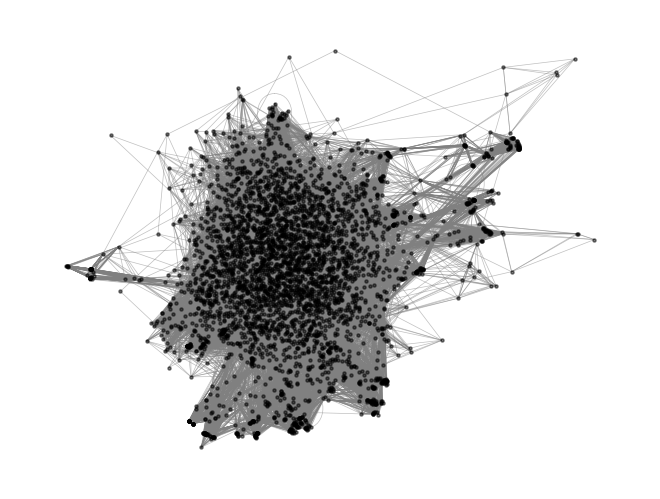

In [74]:

## Load the full coauthorship network
fpath = "../resources/ca-AstroPh.txt.gz"
# fpath = "../resources/ca-CondMat.txt.gz"
g = nx.read_edgelist(fpath)

## Create a subgraph of the 1000 most connected authors
subgraph = sorted(g.degree, key=lambda x: x[1], reverse=True)[:4000]
subgraph = [x[0] for x in subgraph]
g2 = g.subgraph(subgraph)
# rename nodes to sequential integers as they would appear in an adjacency matrix
g2 = nx.convert_node_labels_to_integers(g2, first_label=0)

pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

# We can think of graphs as large, (often) sparse matrices

+ The adjacency matrix $A$ is a matrix of size $N \times N$ where $N$ is the number of nodes (authors)
+ $A_{ij} = 1$ if there is an edge between nodes $i$ and $j$ (i.e., if authors $i$ and $j$ have coauthored a paper). Otherwise, $A_{ij} = 0$
+ Co-authorship is an undirected graph, so $A$ is symmetric. That means that there are at most $N(N-1)/2$ unique edges in the graph.
+ Usually, there are far fewer than that.

In [75]:
A = nx.adjacency_matrix(g2).todense()
# find sparsity

n = A.shape[0]
density = np.sum(A != 0) / (n * n)
print("Density: {:.2f}%".format(density * 100))

Density: 1.26%


Let's look at this matrix a little more closely...

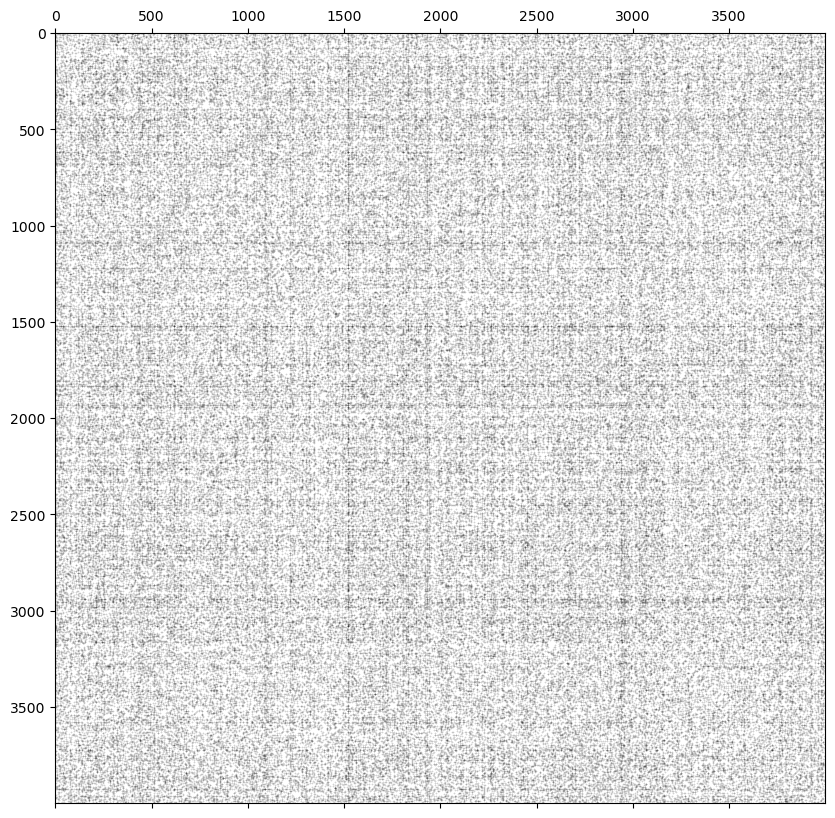

In [83]:
plt.figure(figsize=(10, 10))
plt.spy(A, markersize=0.05, color='k') # a spy plot is a plot of the sparsity pattern of a matrix

### A random walk on the graph of `astro-ph` coauthorship

+ We can think of a random walk on the graph as a random walk on the adjacency matrix $A$
+ The probability of transitioning from node $i$ to node $j$ is $A_{ij} / \sum_k A_{ik}$
+ The probability of transitioning from node $i$ to node $j$ in $n$ steps is $A^n_{ij} / \sum_k A^n_{ik}$

For the coauthorship graph, we can think of this as a highly-simplified model of collaboration: I initially collaborate with one node (like my PhD advisor). I then randomly choose one of their collaborators, and so on. 

In this simplified model, the probability of collaborating with a given author is proportional to the number of collaborators they have. So authors with high degree (many collaborators) are more likely to be chosen eventually


We thus introduce the degree distribution of the graph, which corresponds to a histogram of the number of edges per node. For this graph, the degree distribution represents the number of cumulative unique coauthors per author.

Text(0, 0.5, 'Number of Authors')

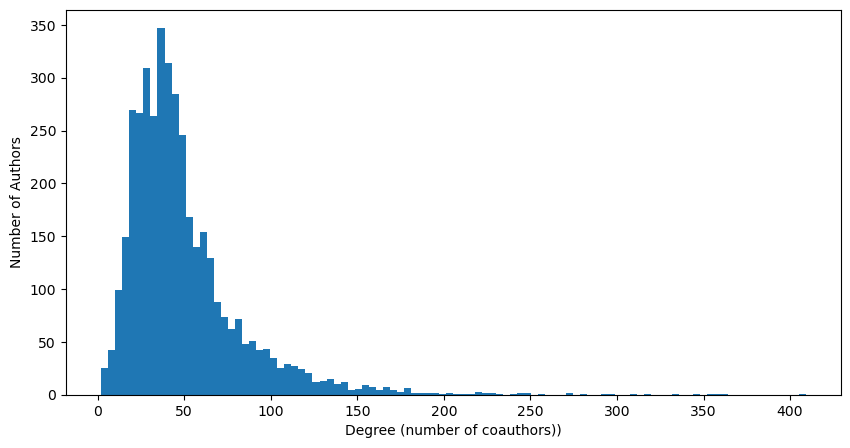

In [84]:
# degree distribution
degrees = np.sum(A, axis=0)
plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=100);
plt.xlabel("Degree (number of coauthors))")
plt.ylabel("Number of Authors")


Now let's implement the random walk on the graph of `astro-ph` coauthorship.

Text(0, 0.5, 'Node')

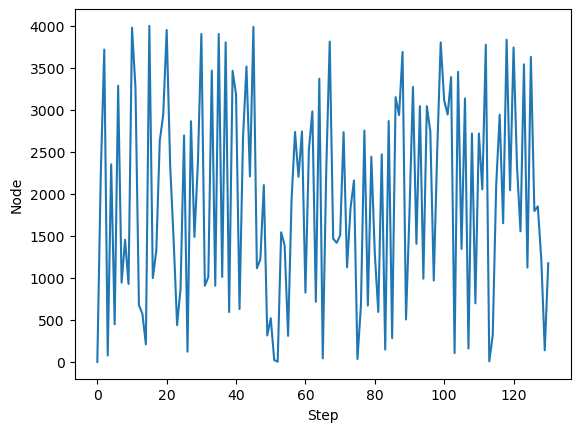

In [92]:
class GraphRandomWalk:
    """A class for performing random walks on a graph

    Parameters:
        A (np.ndarray): The adjacency matrix of the graph
        random_state (int): The random seed to use
        store_history (bool): Whether to store the history of the random walk
    """

    def __init__(self, A, random_state=None, store_history=False):
        self.A = A
        self.n = A.shape[0]
        self.degrees = np.sum(A, axis=0)
        self.D = np.diag(self.degrees)

        self.random_state = random_state
        self.store_history = store_history

        np.random.seed(self.random_state)

        if self.store_history:
            self.history = []

    def step(self, curr):
        """
        Take a single step from a given node to any of its neighbors with equal 
        probability

        Args:
            curr (int): The current node

        Returns:
            nxt (int): The next
        """
        choices = A[curr, :].nonzero()[0]
        nxt = np.random.choice(choices)
        return nxt


    def random_walk(self, start, steps):
        """Perform a random walk on the graph

        Args:
            start (int): The starting node
            steps (int): The number of steps to take

        Returns:
            stop (int): The final node
        """
        curr = start
        if self.store_history:
            self.history.append(start)
        for _ in range(steps):
            curr = self.step(curr)
            if self.store_history:
                self.history.append(curr)

        return curr

model = GraphRandomWalk(A, random_state=0, store_history=True)

# simulate a random walk starting from node 0 for 130 steps
model.random_walk(0, 130)

plt.plot(model.history)
plt.xlabel("Step")
plt.ylabel("Node")

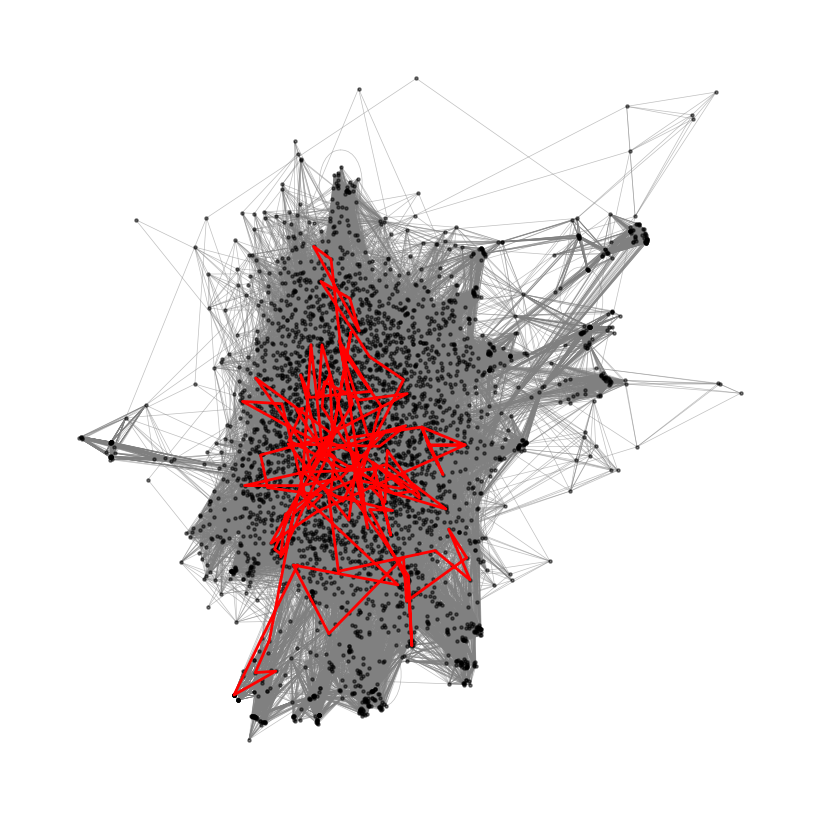

In [94]:

plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
traj = [pos[item] for item in model.history]
plt.plot(*zip(*traj), color='red', linewidth=2)
plt.show()

Now, let's simulate an ensemble of random walks on the graph of `astro-ph` coauthorship.

We will initialize each random walk at the same node (the node with the highest degree, i.e., the author with the most collaborators). We will then simulate the random walk for $n = 100$ steps.

In [345]:
all_traj = []
for _ in range(1000):
    model = GraphRandomWalk(A,  store_history=True)
    model.random_walk(0, 130)
    all_traj.append(np.array(model.history).copy())

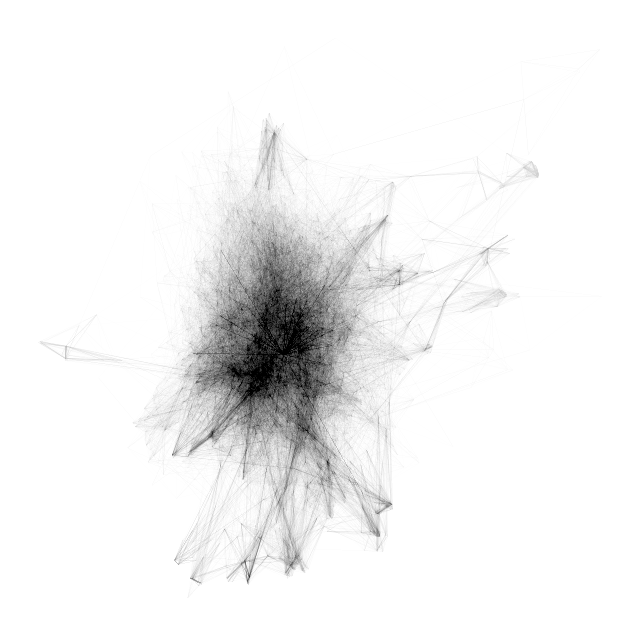

In [348]:
plt.figure(figsize=(8, 8))
for traj in all_traj:
    traj = [pos[item] for item in traj]
    plt.plot(*zip(*traj), color='k', linewidth=.2, alpha=0.01)

plt.axis('off');

### Does the degree alone determine the probability of visiting a node?

+ The degree of a node is the number of edges connected to it
+ We can compare this number to the empirical probability of visiting a node across our ensemble of random walks


Text(0, 0.5, 'Number of visits')

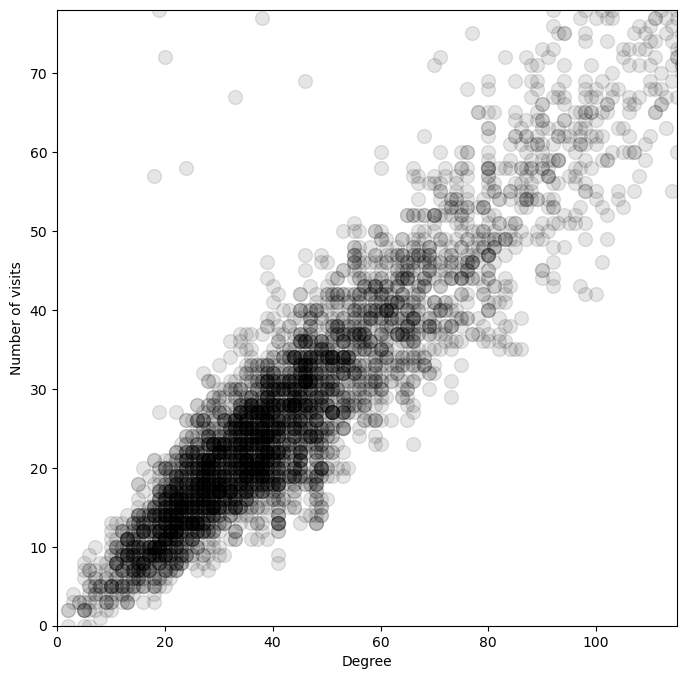

In [374]:
# The degree of each authors
degrees = np.sum(A, axis=0)

# The number of times each author was visited
all_visits = np.hstack(all_traj)
vals, bins = np.histogram(all_visits, bins=np.arange(0, len(degrees) + 1))


plt.figure(figsize=(8, 8))
plt.plot(degrees, vals, '.k', markersize=20, alpha=0.1)
plt.xlim(0, np.percentile(degrees, 95))
plt.ylim(0, np.percentile(vals, 95))

plt.xlabel("Degree")
plt.ylabel("Number of visits")

So the degree distribution tells us a lot about the long-term behavior of our random walk process.
$$
D_i = \sum_j A_{ij} 
$$

We can write the degree distribution as a matrix equation for the vector $D$,

$$
D = A \, \mathbb{1}
$$

where $\mathbb{1}$ is a vector of ones.




